In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
csv1 = "movie_data/movies.csv"
csv2 = "movie_data/ratings.csv"
csv3 = "movie_data/genome-scores.csv"
csv4 = "movie_data/genome-tags.csv"
csv5 = "movie_data/links.csv"
csv6 = "movie_data/tags.csv"

In [144]:
movies_df = pd.read_csv(csv1)
ratings_df = pd.read_csv(csv2)
genome_scores_df = pd.read_csv(csv3)
genome_tags_df = pd.read_csv(csv4)
links_df = pd.read_csv(csv5)
tags_df = pd.read_csv(csv6)

In [4]:
print(f'{len(movies_df)} movies')
print(f'{len(ratings_df)} ratings')

62423 movies
25000095 ratings


In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
# # Number of ratings for each userId
# ratings_df.groupby(ratings_df['userId'])['rating'].count()

In [ ]:
genome_scores_df.head()

In [ ]:
relevant_genome_scores_df = genome_scores_df.loc[genome_scores_df['relevance'] > .85]

In [ ]:
genome_tags_df.head()

In [ ]:
links_df.head()

In [ ]:
tags_df.head()

In [ ]:
new_df = ratings_df.merge(movies_df, how="inner")
new_df = new_df.drop(columns=['title', 'genres', 'timestamp'])
new_df.head()

In [ ]:
new_df["rating"] = np.where(new_df["rating"] >= 3.5, 1, 0)

In [ ]:
new_df

In [ ]:
X = new_df.drop('rating', axis=1)
y = new_df['rating']

In [ ]:
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)

#view transformed values
print(y_transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, random_state=1)

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

In [145]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [151]:
movie_ratings = movies_df.merge(ratings_df, how="inner")
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517
...,...,...,...,...,...,...
25000090,209157,We (2018),Drama,119571,1.5,1574280748
25000091,209159,Window of the Soul (2001),Documentary,115835,3.0,1574280985
25000092,209163,Bad Poems (2018),Comedy|Drama,6964,4.5,1574284913
25000093,209169,A Girl Thing (2001),(no genres listed),119571,3.0,1574291826


In [149]:
# movie_ratings.groupby('movieId').mean()

In [153]:
movie_ratings['year'] = movie_ratings.title.str.extract('\((.*)\)')[0]

In [171]:
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517,1995


In [ ]:
# movie_ratings_genome = ratings_df.merge(relevant_genome_scores_df, how="inner")
# movie_ratings_genome.head()

In [ ]:
# movie_ratings_genome["rating"] = np.where(movie_ratings_genome["rating"] >= 3.5, 1, 0)

In [ ]:
# movie_ratings_genome.head()

In [105]:
genres = ['Comedy','Adventure','Animation','Children','Fantasy','Romance','Drama',
          'Documentary','Action','Horror','Mystery','Sci-Fi','Western','Crime','Thriller',
          'Film-Noir','Musical','War']

In [106]:
def genre_ratings(genre):
    df = movies_df[movies_df['genres'].str.contains(genre, regex=False)]
    genre_df = ratings_df.merge(df, how="inner")
    return genre_df

In [107]:
genre_averages = {
    'Genre': [],
    'Average Rating': []
}
for genre in genres:
    avg_rating = genre_ratings(genre)['rating'].mean()
    genre_averages['Genre'].append(genre)
    genre_averages['Average Rating'].append(avg_rating)

genre_avg_df = pd.DataFrame(genre_averages).sort_values('Average Rating', ascending=False)

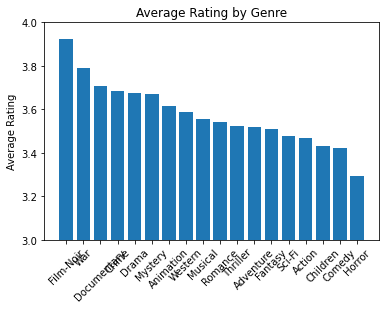

In [100]:
plt.bar(genre_avg_df['Genre'],genre_avg_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.savefig('avg_rating_by_genre.png')

In [175]:
years = ['1995','1996','1997','1998','1999']

In [217]:
def ratings_by_year(genre, year):
    df = movie_ratings[movie_ratings['genres'].str.contains(genre, regex=False)]
    year_df = df.loc[movie_ratings['year'] == year]
    avg_rating = year_df.groupby('year')['rating'].mean()
    return avg_rating[0]

In [218]:
ratings_by_year('Action','1995')

3.256563264751201

In [219]:
ratings_dict = {
    'Year': [],
    'Average Rating': []
}

for year in years:
    avg = ratings_by_year('Action',year)
    ratings_dict['Average Rating'].append(avg)
    ratings_dict['Year'].append(year)
    
ratings_dict_df = pd.DataFrame(ratings_dict)

In [220]:
ratings_dict_df

,Year,Average Rating
0,1995,3.256563
1,1996,3.238403
2,1997,3.126484
3,1998,3.334413
4,1999,3.544421


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

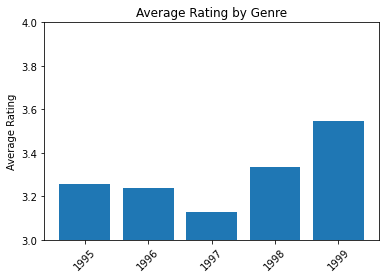

In [221]:
plt.bar(ratings_dict_df['Year'],ratings_dict_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)